<b>I Know What You Did Last Summer: Visualizing Every Search Term You've Ever Put In Google</b>

 - Intro about Google Search Data and this article

<b>Downloading data from Google</b>

- Instructions on how to download data

<b>HTML Parsing using Beautiful Soup</b>

- Include Github link and describe html parsing to .csv file

<b>Data Cleaning</b>

- Remove erroneous data

In [1]:
import os
import pandas as pd
import nltk
import gensim.downloader as api
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk.tokenize.treebank import TreebankWordDetokenizer
import matplotlib.pyplot as plt

In [2]:
dataDF = pd.read_csv('./D_searchData.csv')

In [3]:
dataDF.head()

,Term,Day,Month,Year
0,download my own google search history,17,5,2020
1,download all google search terms,17,5,2020
2,text data mining,17,5,2020
3,what data does google have on me,17,5,2020
4,google cloud,17,5,2020


In [4]:
dataDF.isna().any()

Term      True
Day      False
Month    False
Year     False
dtype: bool

In [5]:
dataDF[dataDF['Term'].isna()]

,Term,Day,Month,Year
4370,NaN,1,1,2020


In [6]:
dataDF.dropna(axis = 0, inplace=True)

Dropping any rows with missing values

In [7]:
dataDF.describe(include = ['object', 'int64'])

,Term,Day,Month,Year
count,61286,6.128600e+04,61286.000000,61286.000000
unique,49362,NaN,NaN,NaN
top,usd to nzd,NaN,NaN,NaN
freq,222,NaN,NaN,NaN
mean,NaN,6.994218e+05,6.462797,2017.027298
std,NaN,7.370126e+07,3.555444,1.939811
min,NaN,0.000000e+00,1.000000,2013.000000
25%,NaN,7.000000e+00,3.000000,2016.000000
50%,NaN,1.600000e+01,6.000000,2017.000000
75%,NaN,2.400000e+01,10.000000,2019.000000


Obtaining a snapshot of the columns in our dataset highlights whether or not we have remove any out of range rows. It is also interesting to see that my most common search term is 'usd to nzd' with a frequency of 222 times. I guess before my various trips between the US and NZ in the past, I've been obsessed with making sure I get the best rate.

We can see that the Month and Year columns seem to be fine, however, the Day column seems to have some really unusually large values mostly likely due to our imperfect parsing script, these rows will be removed.

In [8]:
dataDF = dataDF[(dataDF['Day']<32)&(dataDF['Day']>0)]

Now that we've removed days outside the range 1-31 the next thing we need to do before we can use word embeddings is make sure there aren't any non-English words, symbols (including numbers not in words form).

In [9]:
~dataDF['Term'].str.contains('[A-Za-z]').any()

False

In [10]:
dataDF['Term'].str.contains('[0-9]').any()

False

We also need to make all the words lowercase since the words in the vocabulary are case sensitive

In [11]:
dataDF['Term'] = dataDF['Term'].str.lower()

It seems like we are now reading to do some word embeddings!

In [11]:
#This step is required to download various corpuses from NLTK e.g. Stopwords that we will use below.
#nltk.download()

<b>Using NLTK</b>

We can split up sentences into tokens using NLTK like so:

In [12]:
nltk.word_tokenize("hey there")

['hey', 'there']

The next step for us is to tokenize each sentence in the 'Term' column in our dataframe.

In [13]:
dataDF['Term'] = dataDF['Term'].apply(nltk.word_tokenize)

In [14]:
dataDF.head()

,Term,Day,Month,Year
0,"[download, my, own, google, search, history]",17,5,2020
1,"[download, all, google, search, terms]",17,5,2020
2,"[text, data, mining]",17,5,2020
3,"[what, data, does, google, have, on, me]",17,5,2020
4,"[google, cloud]",17,5,2020


Remove stopwords from our search terms

In [15]:
stopWords = nltk.corpus.stopwords.words('english')

In [16]:
def removeStopWords(words):
    removed = [w for w in words if not w in stopWords]
    
    return removed;

In [17]:
dataDF['Term'] = dataDF['Term'].apply(removeStopWords)

In [18]:
dataDF.head()

,Term,Day,Month,Year
0,"[download, google, search, history]",17,5,2020
1,"[download, google, search, terms]",17,5,2020
2,"[text, data, mining]",17,5,2020
3,"[data, google]",17,5,2020
4,"[google, cloud]",17,5,2020


Finally we will remove any punctuations from our dataset

In [19]:
def removeSymbols(words):
    removed = [w for w in words if w.isalnum()]
    
    return removed;

In [20]:
dataDF['Term'] = dataDF['Term'].apply(removeSymbols)

Now that our dataset is ready, we can import a pre-trained word embedding model using gensim.

In [21]:
word_vectors = api.load('glove-wiki-gigaword-300')

For each row in our dataset, we want to find the equivalent embedding vector which corresponds with each word. 

In [22]:
def embedSentence(sentence):
    embed = map(embedding, sentence)
    
    return list(embed);

def embedding(word):
    try:
        embed = word_vectors[word]
    except Exception:
        embed = word_vectors['unk']
        
    return embed;

In [23]:
embeddedDF = dataDF.copy()

In [24]:
embeddedDF['Term'] = embeddedDF['Term'].apply(embedSentence)

In [25]:
#removes any rows that became empty after removal of stop words etc.
embeddedDF = embeddedDF[embeddedDF['Term'].astype(str)!='[]']

#Will be useful later for combining dataframes
keepIndices = embeddedDF.index

Now compute the average embeddings for each sentence:

In [26]:
def averageEmbedding(sentence):
    average = np.mean(sentence, axis=0)
    
    return average;

In [27]:
embeddedDF['Term'] = embeddedDF['Term'].apply(averageEmbedding)

In [28]:
embeddedDF.index = list(range(0, len(embeddedDF)))

In [29]:
embeddedDF.head()

,Term,Day,Month,Year
0,"[-0.49601, -0.13437551, 0.06628125, -0.1157595...",17,5,2020
1,"[-0.61814, -0.27855802, -0.0037814993, -0.1149...",17,5,2020
2,"[-0.46841466, -0.0130806565, -0.015143998, -0....",17,5,2020
3,"[-0.760085, -0.277661, 0.146445, -0.071456, -0...",17,5,2020
4,"[-0.633345, -0.35017002, -0.011378, -0.46644, ...",17,5,2020


Let us turn the word embeddings into 300 separate features which we will perform PCA on

In [30]:
FeatureColumns = []

for i in range(0, 300):
    FeatureColumns.append('e'+str(i))

In [31]:
FeatureDF = pd.DataFrame(columns = FeatureColumns)
FeatureDF

,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,...,e290,e291,e292,e293,e294,e295,e296,e297,e298,e299


In [32]:
def featurize(sentence, dataframe):
    sentence = pd.Series(sentence, index=FeatureColumns)
    dataframe = dataframe.append(sentence, ignore_index=True)
    
    return dataframe;

In [33]:
#Takes each element of the vector of embeddings and makes it into a separate feature (column) - Takes a while to run...
for i in range(0, len(embeddedDF['Term'])):
    FeatureDF = featurize(list(embeddedDF['Term'][i]), FeatureDF)

In [44]:
tempDF = dataDF.loc[keepIndices, :].copy()

In [45]:
tempDF.index = range(0, len(tempDF))

Detokenize the Search Terms so we can plot them.

In [46]:
def plotWords(dataframe, fileCount=0):    
    plt.figure(num=None, figsize=(12,8), dpi=300)
    ax = plt.subplot(111)
    for i in range(dataframe.shape[0]):
        plt.text(dataframe.iloc[i,0], dataframe.iloc[i,1], str(dataframe.iloc[i,2]),
                color='blue',
                fontdict={'weight': 'light', 'size':2})
    
    plt.axis('off')
    plt.savefig(fname='plot'+str(fileCount), dpi=300)

In [47]:
#Select the month of March 2020
currentDF = pd.concat([FeatureDF.loc[tempDF[(tempDF['Year']==2020)&(tempDF['Month']==3)].index,:],
                       tempDF[(tempDF['Year']==2020)&(tempDF['Month']==3)]], axis=1)

In [48]:
scaler = StandardScaler()
currentScaledDF = scaler.fit_transform(currentDF.loc[:, :'e299'])

In [49]:
tsne = TSNE(n_components=2).fit_transform(currentScaledDF)
tsneDF = pd.DataFrame(tsne, columns=['T1', 'T2'])

In [50]:
currentDF.index = range(0, len(currentDF))

In [51]:
tsneDF = pd.concat([tsneDF, currentDF.loc[:, 'Term':]], axis =1)

In [52]:
tsneDF['Term'] = tsneDF['Term'].apply(TreebankWordDetokenizer().detokenize)

In [53]:
tsneDF.head()

,T1,T2,Term,Day,Month,Year
0,-1.063730,-26.753996,sli,31,3,2020
1,2.387088,5.804800,comcast internet,31,3,2020
2,2.254728,4.943966,windstream internet,31,3,2020
3,3.672879,5.085357,cheapest internet houston reddit,31,3,2020
4,3.416426,5.895097,internet houston,31,3,2020


In [54]:
#Scale between 0 and 1
scaler = MinMaxScaler()
data = scaler.fit_transform(tsneDF.iloc[:, [0,1]])

tsneDF.iloc[:, [0,1]] = data

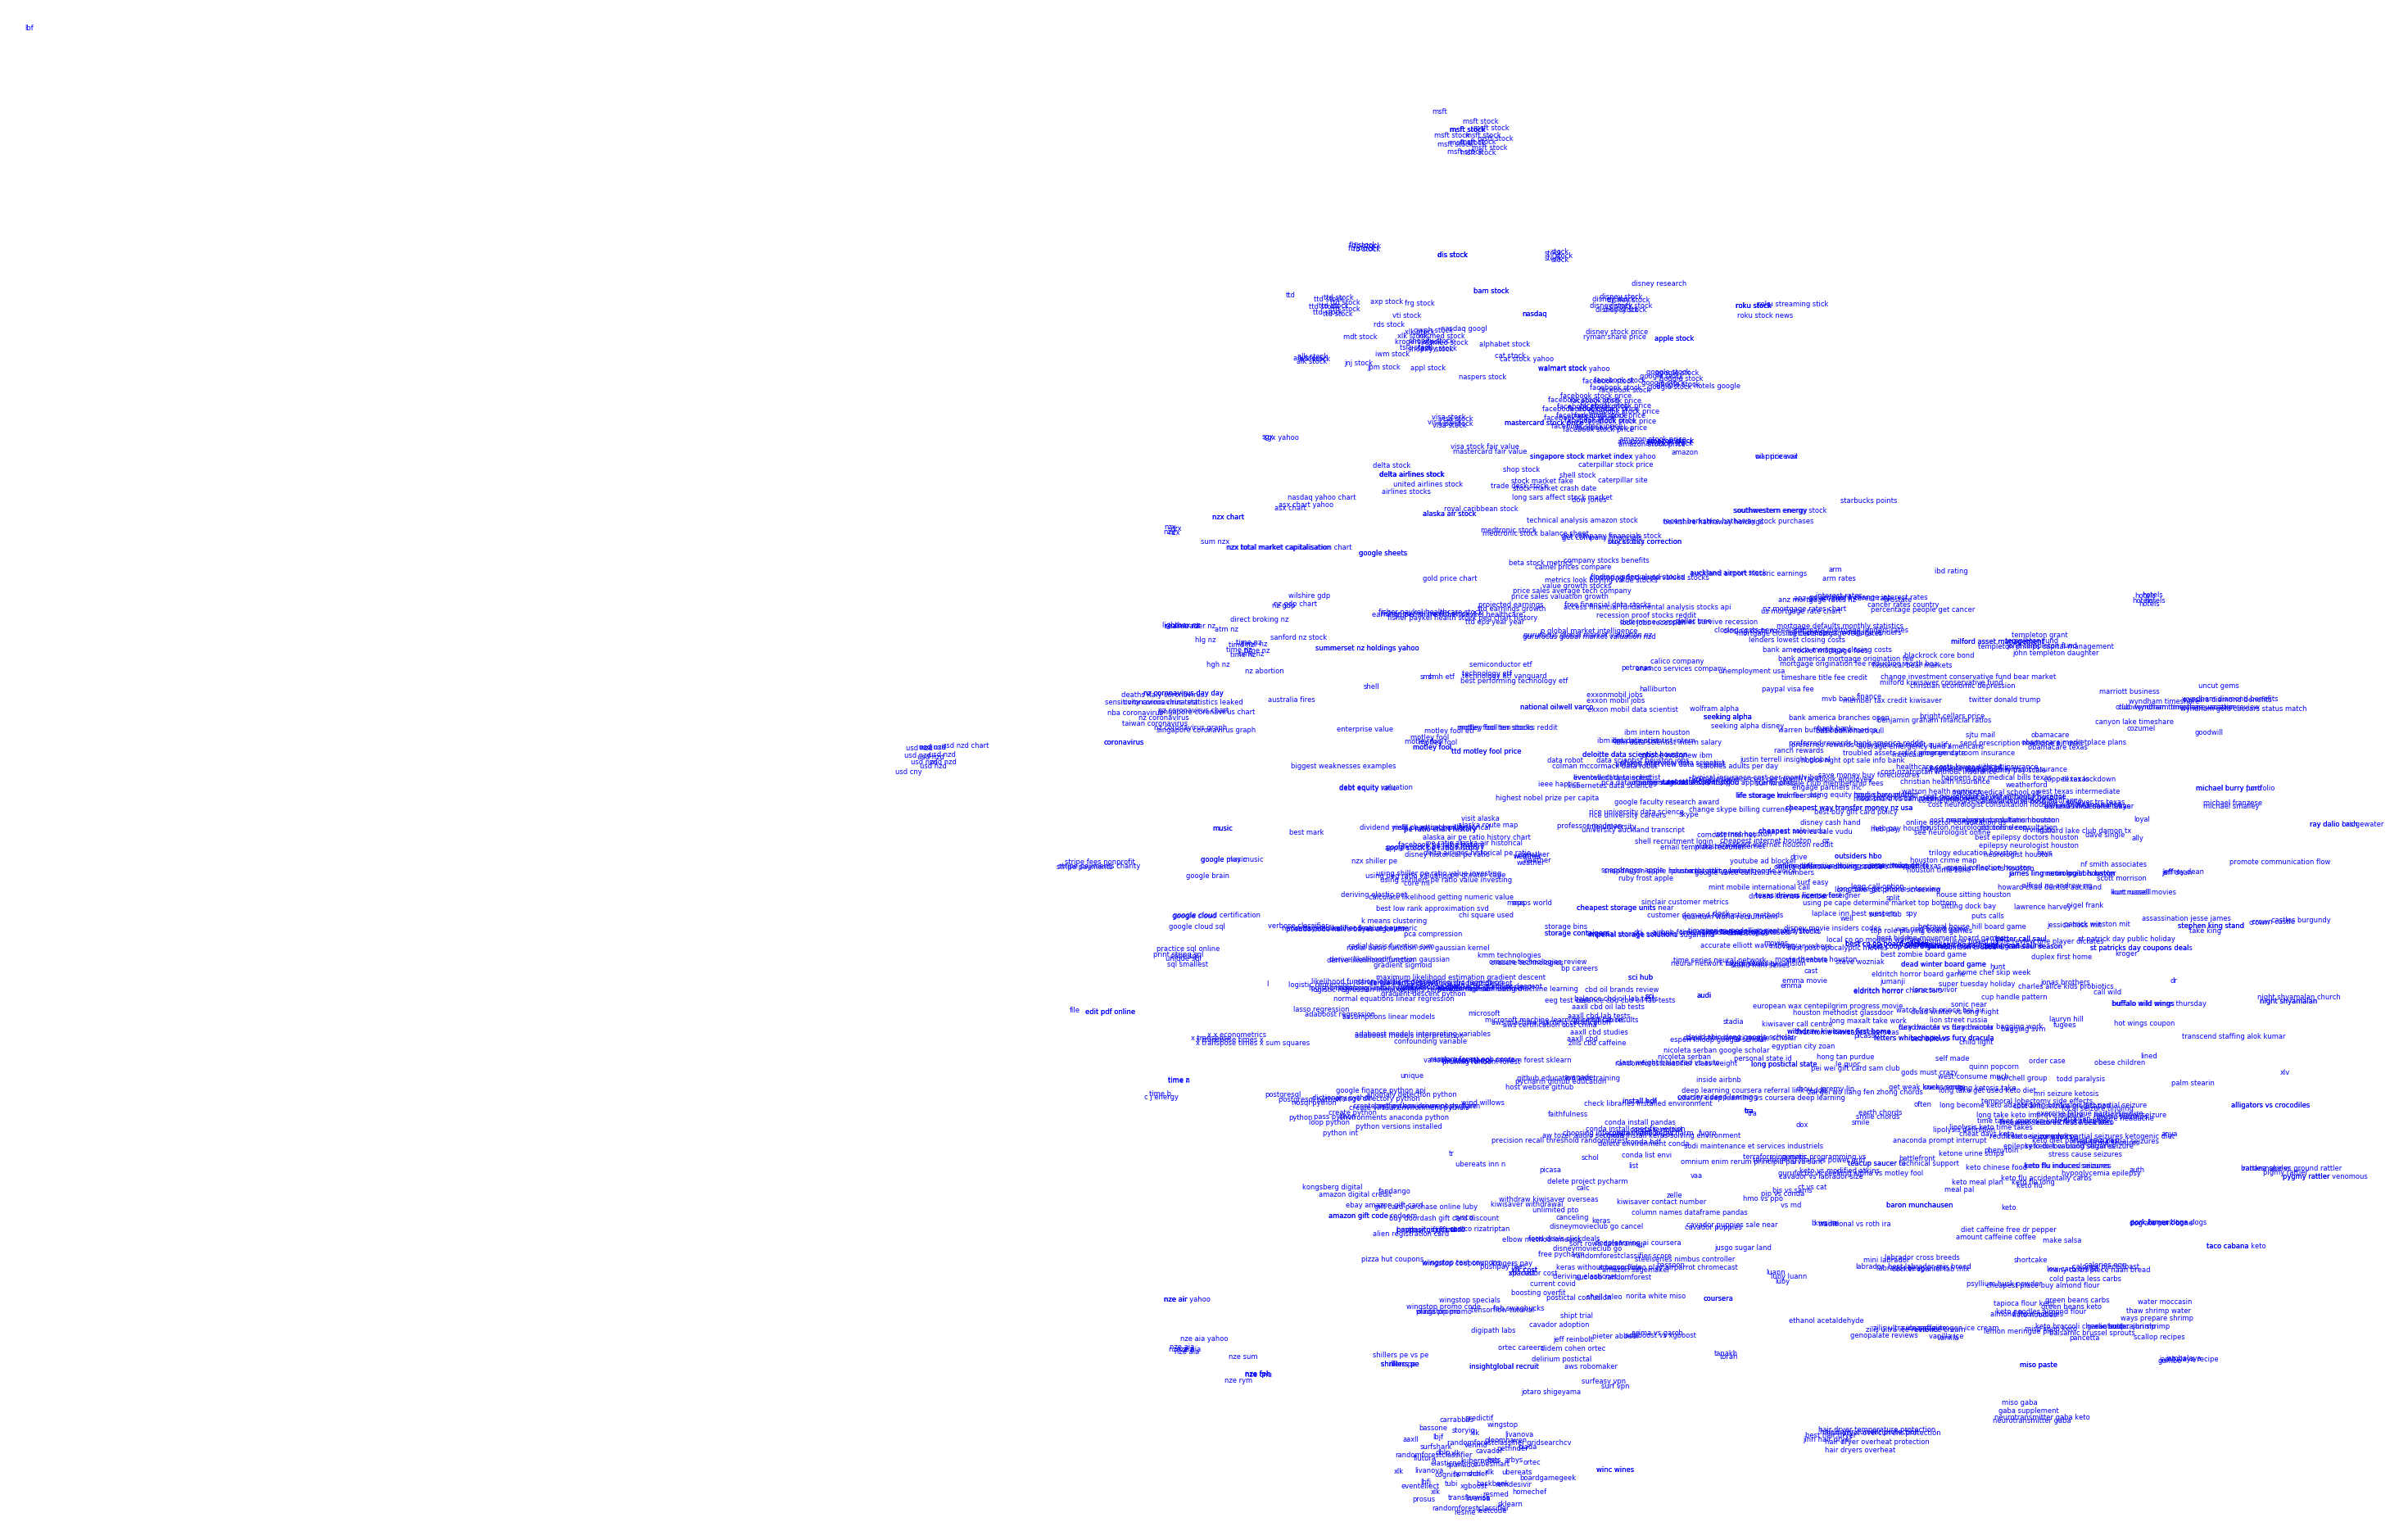

In [55]:
plotWords(tsneDF)

In [ ]:
#tsneCurrentDF = tsneCurrentDF.iloc[::-1]

In [ ]:
#tsneCurrentDF.index = range(0, len(tsneCurrentDF))

In [ ]:
#for i in range(1, tsneCurrentDF['Day'].max()+1):
#    plotWords(tsneCurrentDF[tsneCurrentDF['Day']==i], i)

